# LHC Machine Learing workshop challenge
https://gitlab.cern.ch/IML-WG/IML_challenge_2018/wikis/home

Task: Regress the soft-drop mass of jets with high transverse momentum. Jets are complex physical objects, often containing a spray of particles.https://en.wikipedia.org/wiki/Jet_(particle_physics)

STEP II

In [6]:
from keras import regularizers,optimizers
from keras.layers import Reshape,Flatten,Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,ELU,Dropout,BatchNormalization,concatenate
from keras.models import Model
from keras import backend as K
from keras import callbacks
from keras.utils import plot_model

Load the training constituents

In [3]:
import numpy as np
train_consts_trial=np.load('train_consts.npz') #load the training constitutents
train_consts_trial.shape

(3000, 1, 8, 130)

Build the autoencoder model, code layer is of length 50

In [2]:
#build the autoencoder model

input_img=Input(shape=(1,8,130))

#encoder



x1=Conv2D(16,(8,1),padding='valid',data_format='channels_first',name='conva')(input_img)
x1=ELU()(x1)
print(x1.shape)
x1=Flatten()(x1)
print(x1.shape)
x1=Dense(100,name='densea')(x1)
x1=ELU()(x1)
x1=Dropout(0.15)(x1)
print(x1.shape)

x2=Conv2D(24,(1,130),padding='valid',data_format='channels_first',name='convb')(input_img)
x2=ELU()(x2)
print(x2.shape)
x2=Flatten()(x2)
print(x2.shape)
x2=Dense(100,name='denseb')(x2)
x2=ELU()(x2)
x2=Dropout(0.25)(x2)
print(x2.shape)

x=concatenate([x1,x2],axis=1)

print(x.shape)
encoded=Dense(50,name='densec')(x)
#encoded=x
x=ELU()(encoded)
print(x.shape)
x=Dense(100,name='densed')(x)
x=ELU()(x)
x=Dropout(0.25)(x)
print(x.shape)
x=Dense(8*130,name='densef')(x)
print(x.shape)
decoded=Reshape((1,8,130))(x)

encoder=Model(input_img,encoded)
autoencoder=Model(input_img, decoded)
encoder.compile(optimizer='ADAM', loss='MSE')
autoencoder.compile(optimizer='ADAM', loss='MSE')
autoencoder.summary()

(?, 16, 1, 130)
(?, ?)
(?, 100)
(?, 24, 8, 1)
(?, ?)
(?, 100)
(?, 200)
(?, 50)
(?, 100)
(?, 1040)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 8, 130)    0                                            
__________________________________________________________________________________________________
conva (Conv2D)                  (None, 16, 1, 130)   144         input_1[0][0]                    
__________________________________________________________________________________________________
convb (Conv2D)                  (None, 24, 8, 1)     3144        input_1[0][0]                    
__________________________________________________________________________________________________
elu_1 (ELU)                     (None, 16, 1, 130)   0           conva[0][0]                      
___________

In [8]:
plot_model(autoencoder, to_file='model.png')

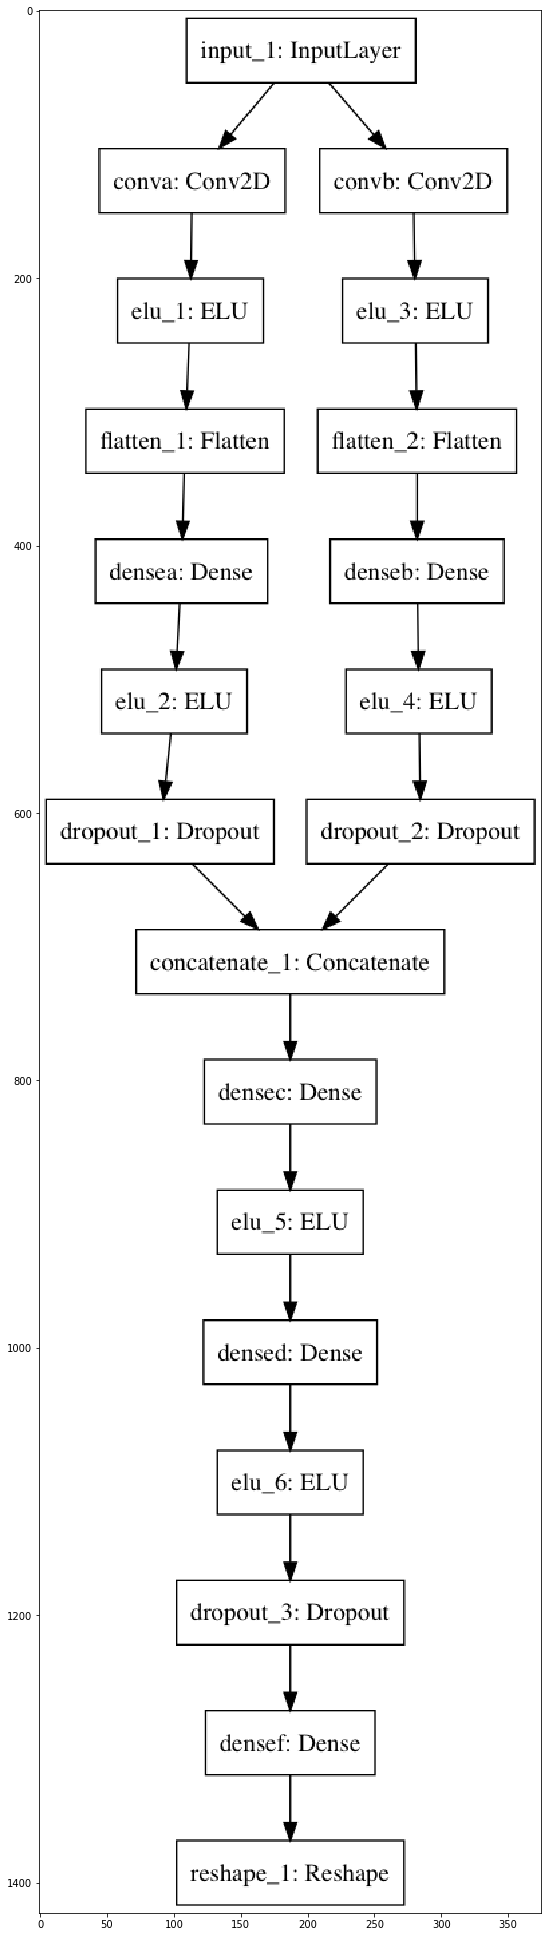

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [40, 35]
X=plt.imread("model.png")
plt.imshow(X)

In [29]:
for _ in range(2): #train_autoendor*.py does the training on gpu
    sd=autoencoder.fit(x=train_consts_trial, y=train_consts_trial, epochs=1,batch_size=32,
                validation_data=[train_consts_trial,train_consts_trial],
                verbose=1,
                )

Train on 3000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 2s - loss: 852282.7268 - val_loss: 427665.1363
Train on 3000 samples, validate on 3000 samples
Epoch 1/1
3000/3000 [==============================] - 2s - loss: 796624.0172 - val_loss: 530321.5847


In [32]:
print(my_hist.history['val_loss'][0])

530321.584667


In [22]:
autoencoder.save('autoencoder.h5')
encoder.save('encoder.h5')
encoder.save_weights('encoder_weights.h5')

Next step is training the supervised regressor. Code of the autoencoder and the reconstructed quantities go as feature vector. See train_regressor document